In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister
from qiskit import Aer
from qiskit.opflow import X, Z, I, MatrixEvolution
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.circuit import Parameter
from qiskit import transpile
from scipy import linalg
from scipy.special import binom
import matplotlib.pyplot as plt
from qutip import *
import itertools as it
import copy
import stomp_functions as stf
from qiskit.quantum_info import random_clifford
import time
from qiskit.providers.fake_provider import FakeBelem
from qiskit.circuit.random import random_circuit

/tmp/ipykernel_2906429/1407063873.py:4: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import X, Z, I, MatrixEvolution


In [2]:
def create_H(N, g, j):
    z_ops, x_ops = stf.construct_op_lists(N)
    
    # Construct the Hamiltonian
    # Loop over sites to construct parts of H
    H_qis = 0
    for n in range(N-1):
        H_qis += -j * z_ops[n] @ z_ops[n+1]
        for m in range(N):
            H_qis += -j * g * x_ops[n]

    return H_qis

In [3]:
# Set font size of plot elements
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
# Define Hamiltonian parameters
N = 2
g = 2
j = 1

In [5]:
backend = Aer.get_backend('aer_simulator')
#backend = 
num_shots = 1*8192

# Set up parameters for unitary
beta = 0.08
num_steps = 40
betas, dt = np.linspace(0, beta, num_steps, retstep=True)

## Get overlaps via Hadamard test
For now we're just focusing on the overlaps with no observable

In [6]:
# Create Hamiltonian
z_ops, x_ops = stf.construct_op_lists(N)

H = create_H(N, g, j)
E, V = linalg.eigh(H.to_matrix())

In [7]:
# Create circuit registers and initializing gate
qr = QuantumRegister(N)
qar = AncillaRegister(1)
cr = ClassicalRegister(1)
cliff = random_clifford(N, seed=5)

In [8]:
# Get circuits for real and imaginary Hadamard estimation with no observable
he_circs_re = stf.had_est_barr(qr, qar, cr, H, None, num_steps, 
                                      dt, cliff)
he_circs_im = stf.im_had_est_barr(qr, qar, cr, H, None, num_steps, 
                                      dt, cliff)

In [9]:
# Get the overlap lists for the circuits with no observables
ovlps_r = stf.get_ovlps(he_circs_re, backend, num_shots)
ovlps_i = stf.get_ovlps(he_circs_im, backend, num_shots)
ovlps = ovlps_r + 1j * ovlps_i

In [10]:
# Now that we have the overlaps, we want to calculate the expectation value of H at each step
pauli_H = stf.pauli_string_decomp(H, 2)

In [11]:
# Now perform hadmard estimation on each string
H_circs_r = {}
H_circs_i = {}
for key in pauli_H:
    if abs(pauli_H[key]) != 0:
        H_circs_r[key] = stf.had_est_barr(qr, qar, cr, H, Pauli(key), num_steps, dt,
                                                 cliff)
        
        H_circs_i[key] = stf.im_had_est_barr(qr, qar, cr, H, Pauli(key), num_steps,
                                                                   dt, cliff)

In [12]:
# Get real part of H expectations
H_ovlps_re = 0
for key in H_circs_r:
    temp = stf.get_ovlps(H_circs_r[key], backend, num_shots)
    H_ovlps_re += pauli_H[key] * temp / np.sqrt(2 ** (2*N))

In [13]:
# Get imag part of H expectations
H_ovlps_im = 0
for key in H_circs_i:
    temp = stf.get_ovlps(H_circs_i[key], backend, num_shots)
    H_ovlps_im += 1j * pauli_H[key] * temp / np.sqrt(2 ** (2*N))

In [14]:
# Get total H expectation
total_H_ovlp = H_ovlps_re + H_ovlps_im

## Get expectation values of U, U^\dag

In [54]:
def expt_value(cliff, U, N, backend, num_shots, obs_pauli=None):
    qr = QuantumRegister(N)
    cr = ClassicalRegister(N)
    
    # Get pauli string decomposition of U
    paulis = stf.pauli_string_decomp(U, N)
    
    circ_results = []
    circs = []
    for key in paulis:
        if abs(paulis[key]) > 1e-8:
            circ = QuantumCircuit(qr, cr)
            circ.append(cliff.to_circuit(), qr)
            
            circ.append(Pauli(key), qr)
            
            
            for i, _ in enumerate(key):
                if _ == 'X':
                    circ.h(i)
        
                if _ == 'Y':
                    circ.rx(np.pi/2, i)
                
            circ.measure([0, 1], [0, 1])
            circs.append(circ)
            tc = transpile(circ, backend)
            counts = backend.run(tc, shots=num_shots).result().get_counts()
        
            probs = {}
            for output in ['00', '01', '10', '11']:
                if output in counts:
                    probs[output] = counts[output] / num_shots
                else:
                    probs[output] = 0
            
            coeff = paulis[key]
            circ_results.append(
                (probs['00'] - probs['01'] - probs['10'] + probs['11']) * coeff / np.sqrt(2 ** (2*N))
        )
        
    return np.array(circ_results)

In [55]:
fwd_expt_vals = []
bck_expt_vals = []
for n in range(num_steps):
    U_sq = (-float(2 * n * np.sqrt(dt / 2)) * H).exp_i()
    fwd_expt_vals.append(expt_value(cliff, U_sq, N, backend, num_shots))
    
    U_dag_sq = (float(2 * n * np.sqrt(dt / 2)) * H).exp_i()
    bck_expt_vals.append(expt_value(cliff, U_dag_sq, N, backend, num_shots))

In [60]:
fwd_expt_vals

[array([-0.00366211+0.j]),
 array([0.00565623+0.j        , 0.        +0.2532373j ,
        0.        -0.00089647j]),
 array([0.01982183+0.j        , 0.        +0.48891534j,
        0.        +0.00137269j]),
 array([0.00051433+0.j        , 0.        +0.69069239j,
        0.        -0.00257155j]),
 array([-0.00264281+0.j        ,  0.        +0.84457739j,
         0.        -0.00443321j]),
 array([0.00447575+0.00000000e+00j, 0.        +9.39900079e-01j,
        0.        +7.45770326e-04j]),
 array([-2.68436342e-05+0.j        ,  0.00000000e+00+0.97005087j,
         0.00000000e+00+0.00278274j]),
 array([0.00528995-0.00000000e+00j, 0.        +9.32939122e-01j,
        0.        +2.27768340e-04j]),
 array([0.00805915-0.j        , 0.        +0.83113814j,
        0.        -0.00304372j]),
 array([-0.01021703+0.j        ,  0.        +0.67170672j,
         0.        +0.00254186j]),
 array([-0.00556849+0.j        ,  0.        +0.4656997j ,
         0.        +0.00221708j]),
 array([0.01234162-0.j   

In [17]:
fwd = np.array(fwd_expt_vals)
bck = np.array(bck_expt_vals)

In [18]:
U_sq = (-float(2 * 1 * np.sqrt(dt / 2)) * H).exp_i()
test = stf.pauli_string_decomp(U_sq, 2)
test

{'II': (3.8613216328846303+0j),
 'IX': 0j,
 'IY': 0j,
 'IZ': 0j,
 'XI': -1.0129492165040475j,
 'XX': 0j,
 'XY': 0j,
 'XZ': (-3.10133847586221e-18+0j),
 'YI': 0j,
 'YX': 0j,
 'YY': 0j,
 'YZ': 3.10133847586221e-18j,
 'ZI': 0j,
 'ZX': 0j,
 'ZY': 0j,
 'ZZ': -0.25323730412601186j}

In [19]:
test = []
ψ_0 = cliff.to_matrix() @ np.array([1, 0, 0, 0])
for n in range(num_steps):
    U_sq = (-float(2 * n * np.sqrt(dt / 2)) * H).exp_i()
    test.append(ψ_0.conj().T @ U_sq.to_matrix() @ ψ_0)
    
test = np.array(test)

In [20]:
Pauli('ZZ').to_matrix() 

array([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j]])

In [52]:
ψ_0.conj().T @ Pauli('ZZ').to_matrix() @ ψ_0

0j

In [22]:
test[1]

(0.9653304082211571+0j)

In [23]:
3.88/4

0.97

In [24]:
U_sq = (-float(2 * 1 * np.sqrt(dt / 2)) * H).exp_i()
U_sq.to_matrix()

array([[ 9.65330408e-01-0.06330933j,  0.00000000e+00+0.j        ,
         0.00000000e+00-0.2532373j ,  0.00000000e+00+0.j        ],
       [ 0.00000000e+00+0.j        ,  9.65330408e-01+0.06330933j,
         0.00000000e+00+0.j        ,  0.00000000e+00-0.2532373j ],
       [-1.55066924e-18-0.2532373j ,  0.00000000e+00+0.j        ,
         9.65330408e-01+0.06330933j,  0.00000000e+00+0.j        ],
       [ 0.00000000e+00+0.j        ,  1.55066924e-18-0.2532373j ,
         0.00000000e+00+0.j        ,  9.65330408e-01-0.06330933j]])

In [25]:
cliff.to_matrix()

array([[ 0.5+0.j ,  0.5+0.j ,  0.5+0.j ,  0.5+0.j ],
       [ 0.5+0.j , -0.5+0.j , -0.5+0.j ,  0.5+0.j ],
       [ 0. +0.5j,  0. +0.5j,  0. -0.5j,  0. -0.5j],
       [ 0. -0.5j,  0. +0.5j,  0. -0.5j,  0. +0.5j]])

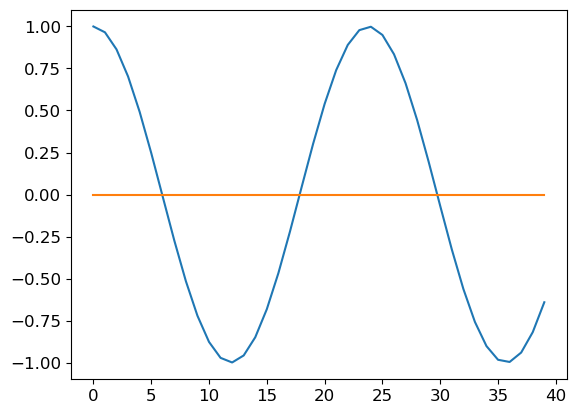

In [26]:
plt.plot(test.real)
plt.plot(test.imag)

In [27]:
ψ_0 = cliff.to_matrix() @ np.array([1, 0, 0, 0])
ψ_0.conj().T @ U_sq.to_matrix() @ ψ_0

(0.9653304082211571+0j)

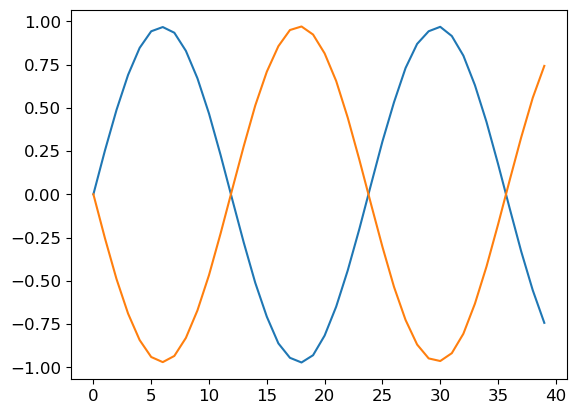

In [28]:
plt.plot(fwd.imag)
plt.plot(bck.imag)

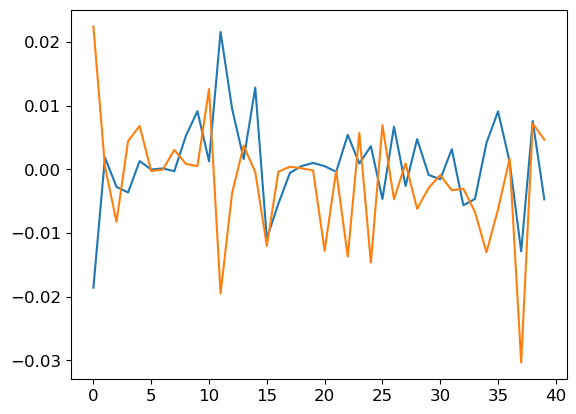

In [29]:
plt.plot(fwd.real)
plt.plot(bck.real)

In [30]:
re = fwd + bck
re /= 2

im = (fwd - bck)
im /= 2

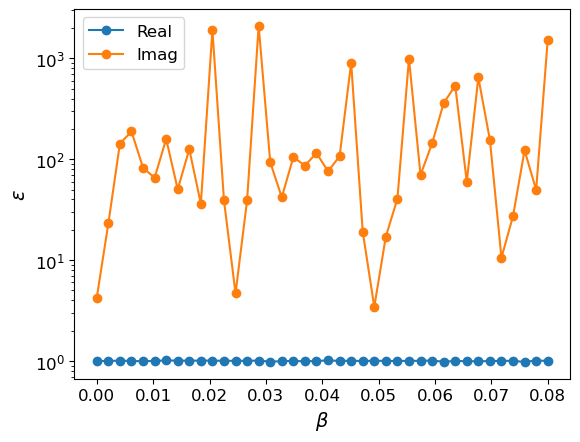

In [31]:
real_rel_err = np.abs(ovlps.real - re) / np.abs(ovlps.real)
im_rel_err = np.abs(ovlps.imag - im) / np.abs(ovlps.imag)
plt.semilogy(betas, real_rel_err, 'o-', label='Real')
plt.semilogy(betas, im_rel_err, 'o-', label='Imag')
plt.xlabel("$\\beta$")
plt.ylabel("$\\epsilon$")
plt.legend()

In [32]:
fwd_H_expt_vals = []
bck_H_expt_vals = []
for n in range(num_steps):
    U_sq = (-float(2 * n * np.sqrt(dt / 2)) * H).exp_i()
    U_dag_sq = (float(2 * n * np.sqrt(dt / 2)) * H).exp_i()
    o_sq = H @ U_sq
    fwd_H_expt_vals.append(expt_value(cliff, o_sq, N, backend, num_shots))
    
    #U_dag_sq = (float(2 * n * np.sqrt(dt / 2)) * H).exp_i()
    o_dag_sq = H @ U_dag_sq
    bck_H_expt_vals.append(expt_value(cliff, o_dag_sq, N, backend, num_shots))

In [33]:
fwd_H = np.array(fwd_H_expt_vals)
bck_H = np.array(bck_H_expt_vals)

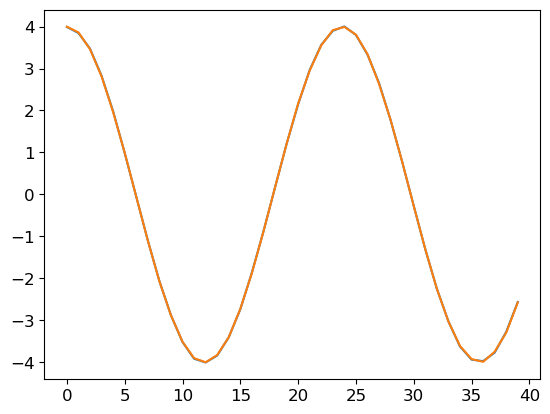

In [34]:
plt.plot(fwd_H.real)
plt.plot(bck_H.real)

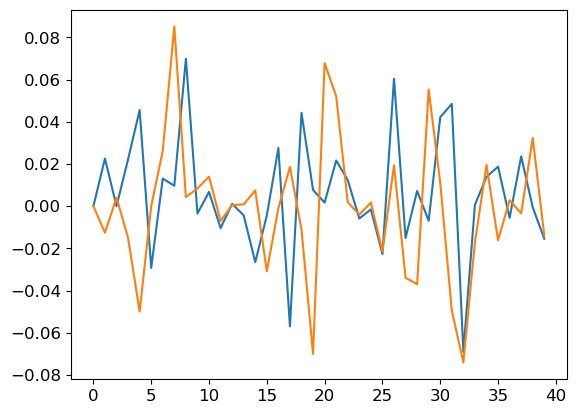

In [35]:
plt.plot(fwd_H.imag)
plt.plot(bck_H.imag)

In [36]:
re_H = (fwd_H + bck_H) / 2

im_H = -1 * (fwd_H - bck_H) / 2

In [37]:
re_H

array([ 3.99291992+0.j        ,  3.85283728+0.00499241j,
        3.46607851+0.00202919j,  2.81809521+0.0035833j ,
        1.96991707-0.00219083j,  0.99022996-0.01462857j,
       -0.05496402+0.01962719j, -1.09753056+0.04743276j,
       -2.06622831+0.03708264j, -2.87855966+0.00243936j,
       -3.51339388+0.01038899j, -3.90707334-0.00873019j,
       -4.00166146+0.00080235j, -3.83268474-0.0017362j ,
       -3.40223542-0.00955805j, -2.7312553 -0.01765965j,
       -1.86886413+0.01334421j, -0.88495778-0.01914362j,
        0.16457377+0.01659507j,  1.20035102-0.03120199j,
        2.15595992+0.03475942j,  2.9566466 +0.03688207j,
        3.55719327+0.00711071j,  3.9058168 -0.00491069j,
        3.99578476+0.00011063j,  3.80286549-0.022103j  ,
        3.33616071+0.03991007j,  2.64245517-0.02451868j,
        1.77152309-0.0148867j ,  0.7771273 +0.02419296j,
       -0.27430233+0.0266124j , -1.30740621-0.00047569j,
       -2.2486063 -0.07159966j, -3.02645848-0.00819997j,
       -3.61670219+0.01670727j,

In [38]:
im_H

array([ 2.68554688e-03-0.j        ,  7.54164381e-03-0.01760482j,
       -6.53698570e-03+0.00202919j, -5.91478539e-03-0.01863318j,
       -7.62812049e-03-0.04776007j,  1.69352791e-03+0.01462857j,
       -5.87204499e-05+0.0065424j , -2.10928358e-03+0.0377526j ,
       -2.07775038e-03-0.03277071j, -1.05693397e-03+0.00592417j,
        2.89132966e-03+0.00362407j,  6.40815091e-03+0.00165166j,
        2.19643552e-03-0.00030434j,  5.26130421e-03+0.0026043j ,
        3.11113673e-04+0.01699208j,  4.49822454e-03-0.01324474j,
       -5.02659219e-03-0.01423382j, -1.91555143e-03+0.03779637j,
        5.03191376e-05-0.02765845j,  3.66945164e-04-0.03888248j,
        7.30521538e-03+0.03306384j, -6.14499568e-03+0.01522654j,
       -4.56356886e-03-0.00527569j,  6.80643118e-03+0.00094035j,
       -5.48486454e-03+0.00160409j,  3.59318572e-03+0.00063151j,
        3.97392467e-03-0.02050934j, -8.64735919e-03-0.00943026j,
        1.56987531e-03-0.02210449j,  1.42183441e-04+0.03110524j,
       -9.38817414e-04-0.

In [39]:
total_H = re_H + im_H

## Comparison

/home/jacob/anaconda3/envs/EnergyGaps/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


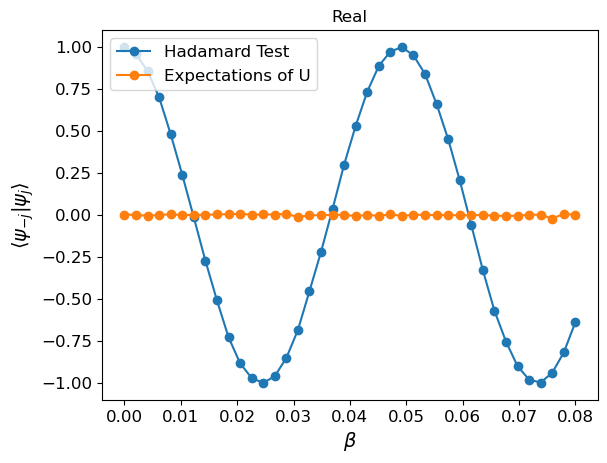

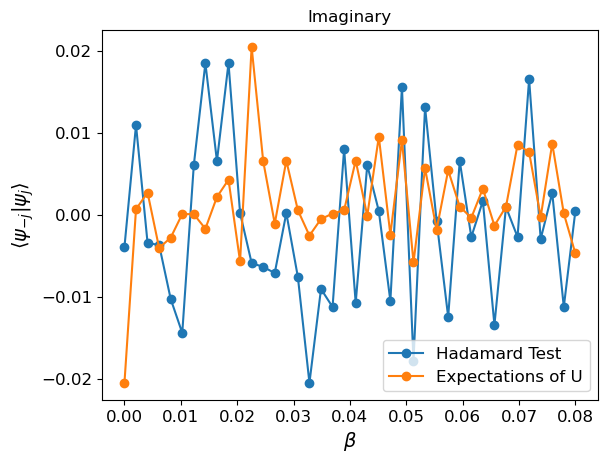

In [40]:
plt.figure(1)
plt.plot(betas, ovlps.real, 'o-', label='Hadamard Test')
plt.plot(betas, re, 'o-', label='Expectations of U')
plt.xlabel("$\\beta$")
plt.ylabel("$\\langle\\psi_{-j}|\\psi_j\\rangle$")
plt.title("Real")
plt.legend()


plt.figure(2)
plt.plot(betas, ovlps.imag, 'o-', label='Hadamard Test')
plt.plot(betas, im, 'o-', label='Expectations of U')
plt.xlabel("$\\beta$")
plt.ylabel("$\\langle\\psi_{-j}|\\psi_j\\rangle$")
plt.title("Imaginary")
plt.legend()

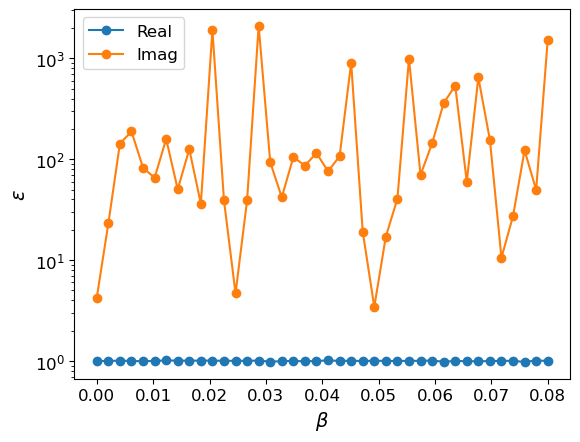

In [41]:
real_rel_err = np.abs(ovlps.real - re) / np.abs(ovlps.real)
im_rel_err = np.abs(ovlps.imag - im) / np.abs(ovlps.imag)
plt.semilogy(betas, real_rel_err, 'o-', label='Real')
plt.semilogy(betas, im_rel_err, 'o-', label='Imag')
plt.xlabel("$\\beta$")
plt.ylabel("$\\epsilon$")
plt.legend()

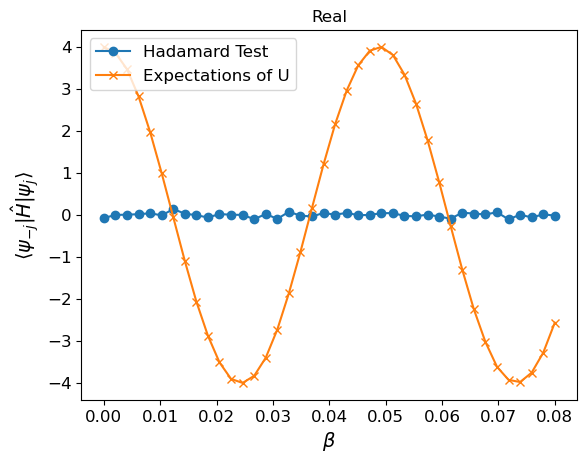

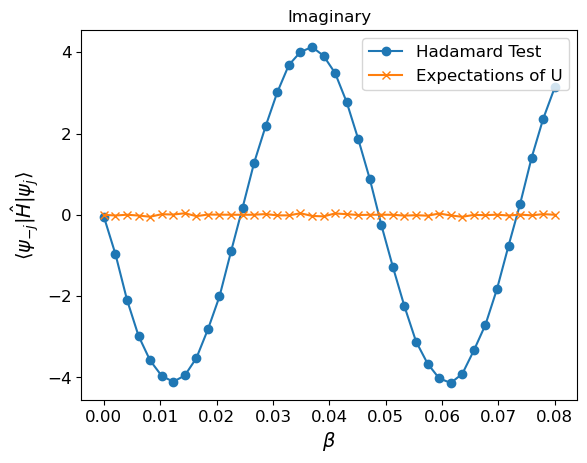

In [42]:
plt.figure(1)
plt.plot(betas, total_H_ovlp.real, 'o-', label='Hadamard Test')
plt.plot(betas, re_H, 'x-', label='Expectations of U')
plt.xlabel("$\\beta$")
plt.ylabel("$\\langle\\psi_{-j}|\\hat{H}|\\psi_j\\rangle$")
plt.title("Real")
plt.legend()


plt.figure(2)
plt.plot(betas, total_H_ovlp.imag, 'o-', label='Hadamard Test')
plt.plot(betas, im_H.imag, 'x-', label='Expectations of U')
plt.xlabel("$\\beta$")
plt.ylabel("$\\langle\\psi_{-j}|\\hat{H}|\\psi_j\\rangle$")
plt.title("Imaginary")
plt.legend()

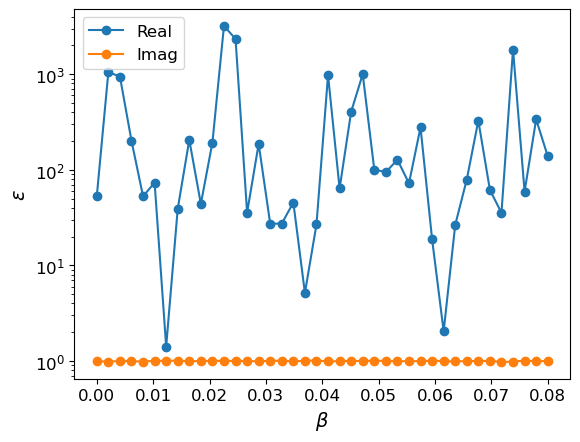

In [43]:
real_rel_err = np.abs(total_H_ovlp.real - re_H) / np.abs(total_H_ovlp.real)
im_rel_err = np.abs(total_H_ovlp.imag - im_H.imag) / np.abs(total_H_ovlp.imag)
plt.semilogy(betas, real_rel_err, 'o-', label='Real')
plt.semilogy(betas, im_rel_err, 'o-', label='Imag')
plt.xlabel("$\\beta$")
plt.ylabel("$\\epsilon$")
plt.legend()

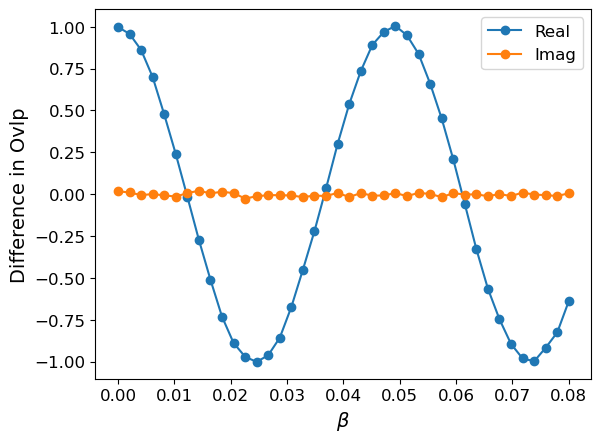

In [44]:
plt.plot(betas, ovlps.real - re, 'o-', label='Real')
plt.plot(betas, ovlps.imag - im, 'o-', label='Imag')
plt.xlabel("$\\beta$")
plt.ylabel("Difference in Ovlp")
plt.legend()

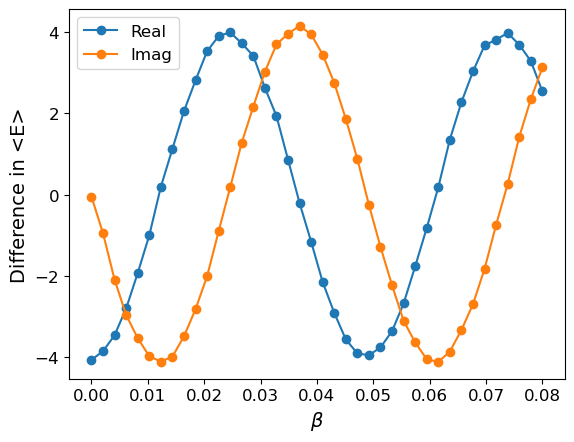

In [45]:
plt.plot(betas, total_H_ovlp.real - re_H, 'o-', label='Real')
plt.plot(betas, total_H_ovlp.imag - im_H.imag, 'o-', label='Imag')
plt.xlabel("$\\beta$")
plt.ylabel("Difference in <E>")
plt.legend()

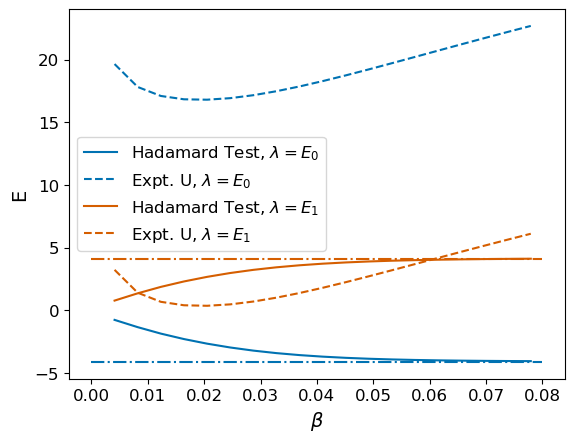

In [46]:
# first plot ground state
λ_0 = 1*E[0]

plt.plot(betas, E[0]*np.ones(len(betas)), '-.', color="#0072B2")
plt.plot(betas[2::2], stf.alt_partition_calc(ovlps, total_H_ovlp, num_steps,
                                             1*λ_0, dt)[1][1:]-1*λ_0, color="#0072B2",
                label='Hadamard Test, $\\lambda=E_0$')
plt.plot(betas[2::2], stf.alt_partition_calc(re+1j*im, re_H+im_H, num_steps,
                                             1*λ_0, dt)[1][1:]-1*λ_0, '--', color="#0072B2",
                label='Expt. U, $\\lambda = E_0$')

# Now plot the first excited state
λ_1 = 1*E[2]
plt.plot(betas, E[2]*np.ones(len(betas)), '-.', color="#D55E00")
plt.plot(betas[2::2], stf.alt_partition_calc(ovlps, total_H_ovlp, num_steps,
                                             λ_1, dt)[1][1:]-λ_1, color="#D55E00",
                label='Hadamard Test, $\\lambda=E_1$')
plt.plot(betas[2::2], stf.alt_partition_calc(re+1j*im, re_H+im_H, num_steps,
                                             λ_1, dt)[1][1:]-λ_1, '--', color="#D55E00",
                label='Expt. U, $\\lambda = E_1$')

plt.xlabel("$\\beta$")
plt.ylabel("E")
plt.legend()


In [47]:
had_test_gs = stf.alt_partition_calc(ovlps, total_H_ovlp, num_steps,
                                             E[0], dt)[1][1:]-E[0]
print(had_test_gs[-1])

expt_u_gs = stf.alt_partition_calc(re+im, re_H+im_H, num_steps,
                                             E[0], dt)[1][1:]-E[0]
print(expt_u_gs[-1])

(-4.061104770306774+0j)
(4.190049540664379+0j)


In [48]:
had_test_es = stf.alt_partition_calc(ovlps, total_H_ovlp, num_steps,
                                             E[2], dt)[1][1:]-E[2]
print(had_test_es[-1])

expt_u_es = stf.alt_partition_calc(re+im, re_H+im_H, num_steps,
                                             E[2], dt)[1][1:]-E[2]
print(expt_u_es[-1])

(4.112105848598456+0j)
(-4.122657170685853+0j)


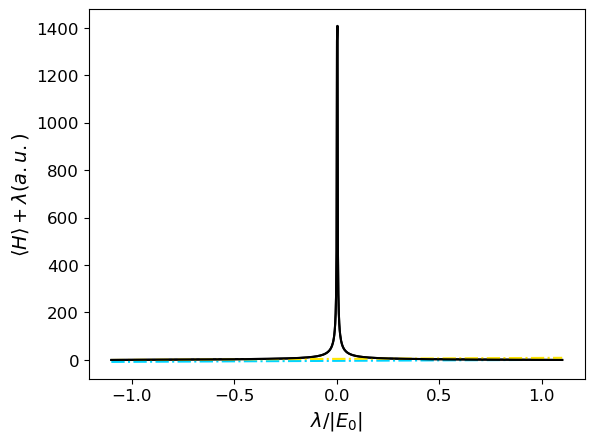

In [49]:
stf.plot_lambda_sweep(re+im, total_H, num_steps, dt, E)